In [1]:
from MALDIMap import MALDINet
from MALDIMap.utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import gc
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='3'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

## Data_6 共1个任务  乳腺癌：胰腺癌：健康= 79：57：84

In [4]:
dfx = LoadMSData(root_path = root_path, data_path = 'data6/peaks_0.8.csv', t = False)
Y = np.zeros((220,3))                                             #将标签以独热编码存起来220
for i in range (0,79):                                           #BC 79例
    Y[i,0] = 1                                                     
for i in range (79,136):                                         #PC 57例
    Y[i,1] = 1                                                    
for i in range (136,220):                                        #HC 84例
    Y[i,2] = 1 
y = Y.astype(int)
Y = np.zeros(220)                                                #用于分层的标签
for i in range (0,79):                                           #BC 79例
    Y[i] = 0                                                    
for i in range (79,136):                                         #PC 57例
    Y[i] = 1
for i in range (136,220):                                        #HC 84例
    Y[i] = 2
Y = Y.astype(int)

In [5]:
mp = AggMap(dfx, metric = 'correlation')                        #使用相关性距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data6', file_type = 'aggmap', file_name = 'aggmap_peaks_0.8.mp')

2024-01-02 09:46:44,165 - INFO - [bidd-aggmap] - Calculating distance ...
2024-01-02 09:46:44,173 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 24/24 [00:00<00:00, 490.79it/s]


2024-01-02 09:46:44,950 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-01-02 09:46:48,819 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-01-02 09:46:48,840 - INFO - [bidd-aggmap] - Finished


In [6]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
#SaveMpOrX(data = X, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_human_0.2.dat')

100%|##########| 220/220 [00:03<00:00, 57.66it/s]


Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


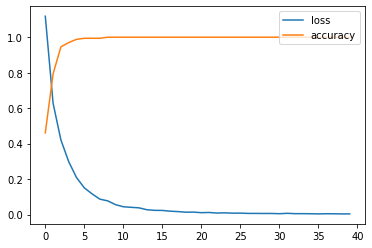

Acc =  0.9636363636363636
f1_score =  0.9636363636363636
average_precision =  0.9636363636363636
recall_score =  0.9636363636363636


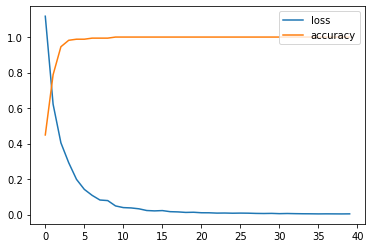

Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


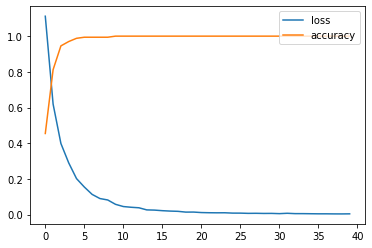

Acc =  0.9818181818181818
f1_score =  0.9818181818181818
average_precision =  0.9818181818181818
recall_score =  0.9818181818181818


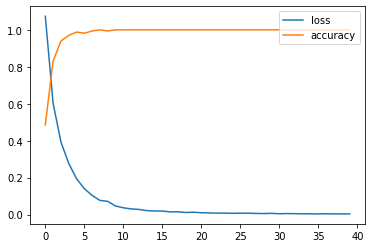

0.9863636363636364

In [20]:
#三核 四折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 4,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[256,128,64],batch_size=64,epochs=40,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 4